In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob
from math import ceil
from skimage import feature
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import jaccard_score

from coring_detector import CoringDetector
from utils import plot_images


### Get Training images

In [2]:
N_images = 50000

In [3]:
imgs_dir = '../data/train/image/*'
imgs_paths = glob(imgs_dir)
imgs_paths = sorted(imgs_paths)
imgs_paths = imgs_paths[:N_images]

train_dataset = [ cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in imgs_paths]

# Padding images to 256x256

# Find the maximum shape among all arrays
max_shape = max(arr.shape for arr in train_dataset)

# Pad or resize each array to the maximum shape
padded_arrays = [np.pad(arr, [(0, max_shape[0] - arr.shape[0]), (0, max_shape[1] - arr.shape[1])], mode='constant', constant_values=int(np.mean(arr))) for arr in train_dataset]

# Convert the list of arrays to a single NumPy array
train_dataset = np.array(padded_arrays)

# Check the shape of the resulting array
print(train_dataset.shape)

(1438, 256, 256)


### Get masks

In [4]:
masks_dir = '../data/train/mask/*'
masks_paths = glob(masks_dir)
masks_paths = sorted(masks_paths)
masks_paths = masks_paths[:N_images]

# Create list with all images in gray scale
masks_gray = [ cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in masks_paths]

# Padding masks to 256x256 

# Find the maximum shape among all arrays
max_shape = max(arr.shape for arr in masks_gray)

# Pad or resize each array to the maximum shape
padded_arrays = [np.pad(arr, [(0, max_shape[0] - arr.shape[0]), (0, max_shape[1] - arr.shape[1])], mode='constant') for arr in masks_gray]

# Convert the list of arrays to a single NumPy array
train_masks = np.array(padded_arrays)

# Get the true centroids for the maks
masks_contours = CoringDetector.find_contours(train_masks)
masks_centroids = CoringDetector.get_centroids(masks_contours)

# plot_images(train_masks, masks_contours, masks_centroids)

# Check the shape of the resulting array
print(train_masks.shape)

(1438, 256, 256)


### Create parameters sets

In [5]:
# Define the parameter ranges and steps
min_area_range = np.arange(1, 10, 5.)  # from 10 to 50, steps of 10
max_area_range = np.arange(400, 450, 50)  # from 250 to 450, steps of 50
min_round_ratio_range = np.arange(0.1, 0.2, 0.1)  # from 0.25 to 0.75, steps of 0.125
max_round_ratio_range = np.arange(0.5, 1.5, 0.5)  # from 1.0 to 3.0, steps of 0.5

canny_sigma_range = np.arange(1, 5, 0.5)
N1_range = np.arange(11, 32, step=2)
N2_fixed = [9]
N3_fixed = [5]

# Construct the param_grid
param_grid =  {
    "min_area": min_area_range,
    "max_area": max_area_range,
    "min_round_ratio": min_round_ratio_range,
    "max_round_ratio": max_round_ratio_range,
    "canny_sigma": canny_sigma_range,
    "N1": N1_range,
    "N2": N2_fixed,
    "N3": N3_fixed,
}

print(f"A total of {len(param_grid)} parameters set were created.")


A total of 8 parameters set were created.


In [6]:
# clf = GridSearchCV(CoringDetector(), param_grid=param_grid, verbose=1, n_jobs=1)
# clf.fit(train_dataset, masks_centroids)

In [7]:
# clf.best_score_

In [8]:
# clf.best_params_

## Resultados

In [16]:
detecor = CoringDetector(metric="f1_score", N1=20, N2=9, N3=5, canny_sigma=2.8, max_area=400, max_round_ratio=1.0, min_area=1.0, min_round_ratio=0.5)
predictions = detecor.fit_transform(train_dataset)
detecor.score(train_dataset, masks_centroids)

0.596931659693166

In [21]:
print("TP", detecor.true_positives_rate)
print("FP", detecor.false_positives_rate)
print("FN", detecor.false_negatives_rate)
print("Recall", detecor.recall)
print("Precision", detecor.precision)
print("f1_score", detecor.f1_score)

TP 0.5952712100139083
FP 0.3991655076495132
FN 0.4047287899860918
Recall 0.5952712100139083
Precision 0.5986013986013986
f1_score 0.596931659693166


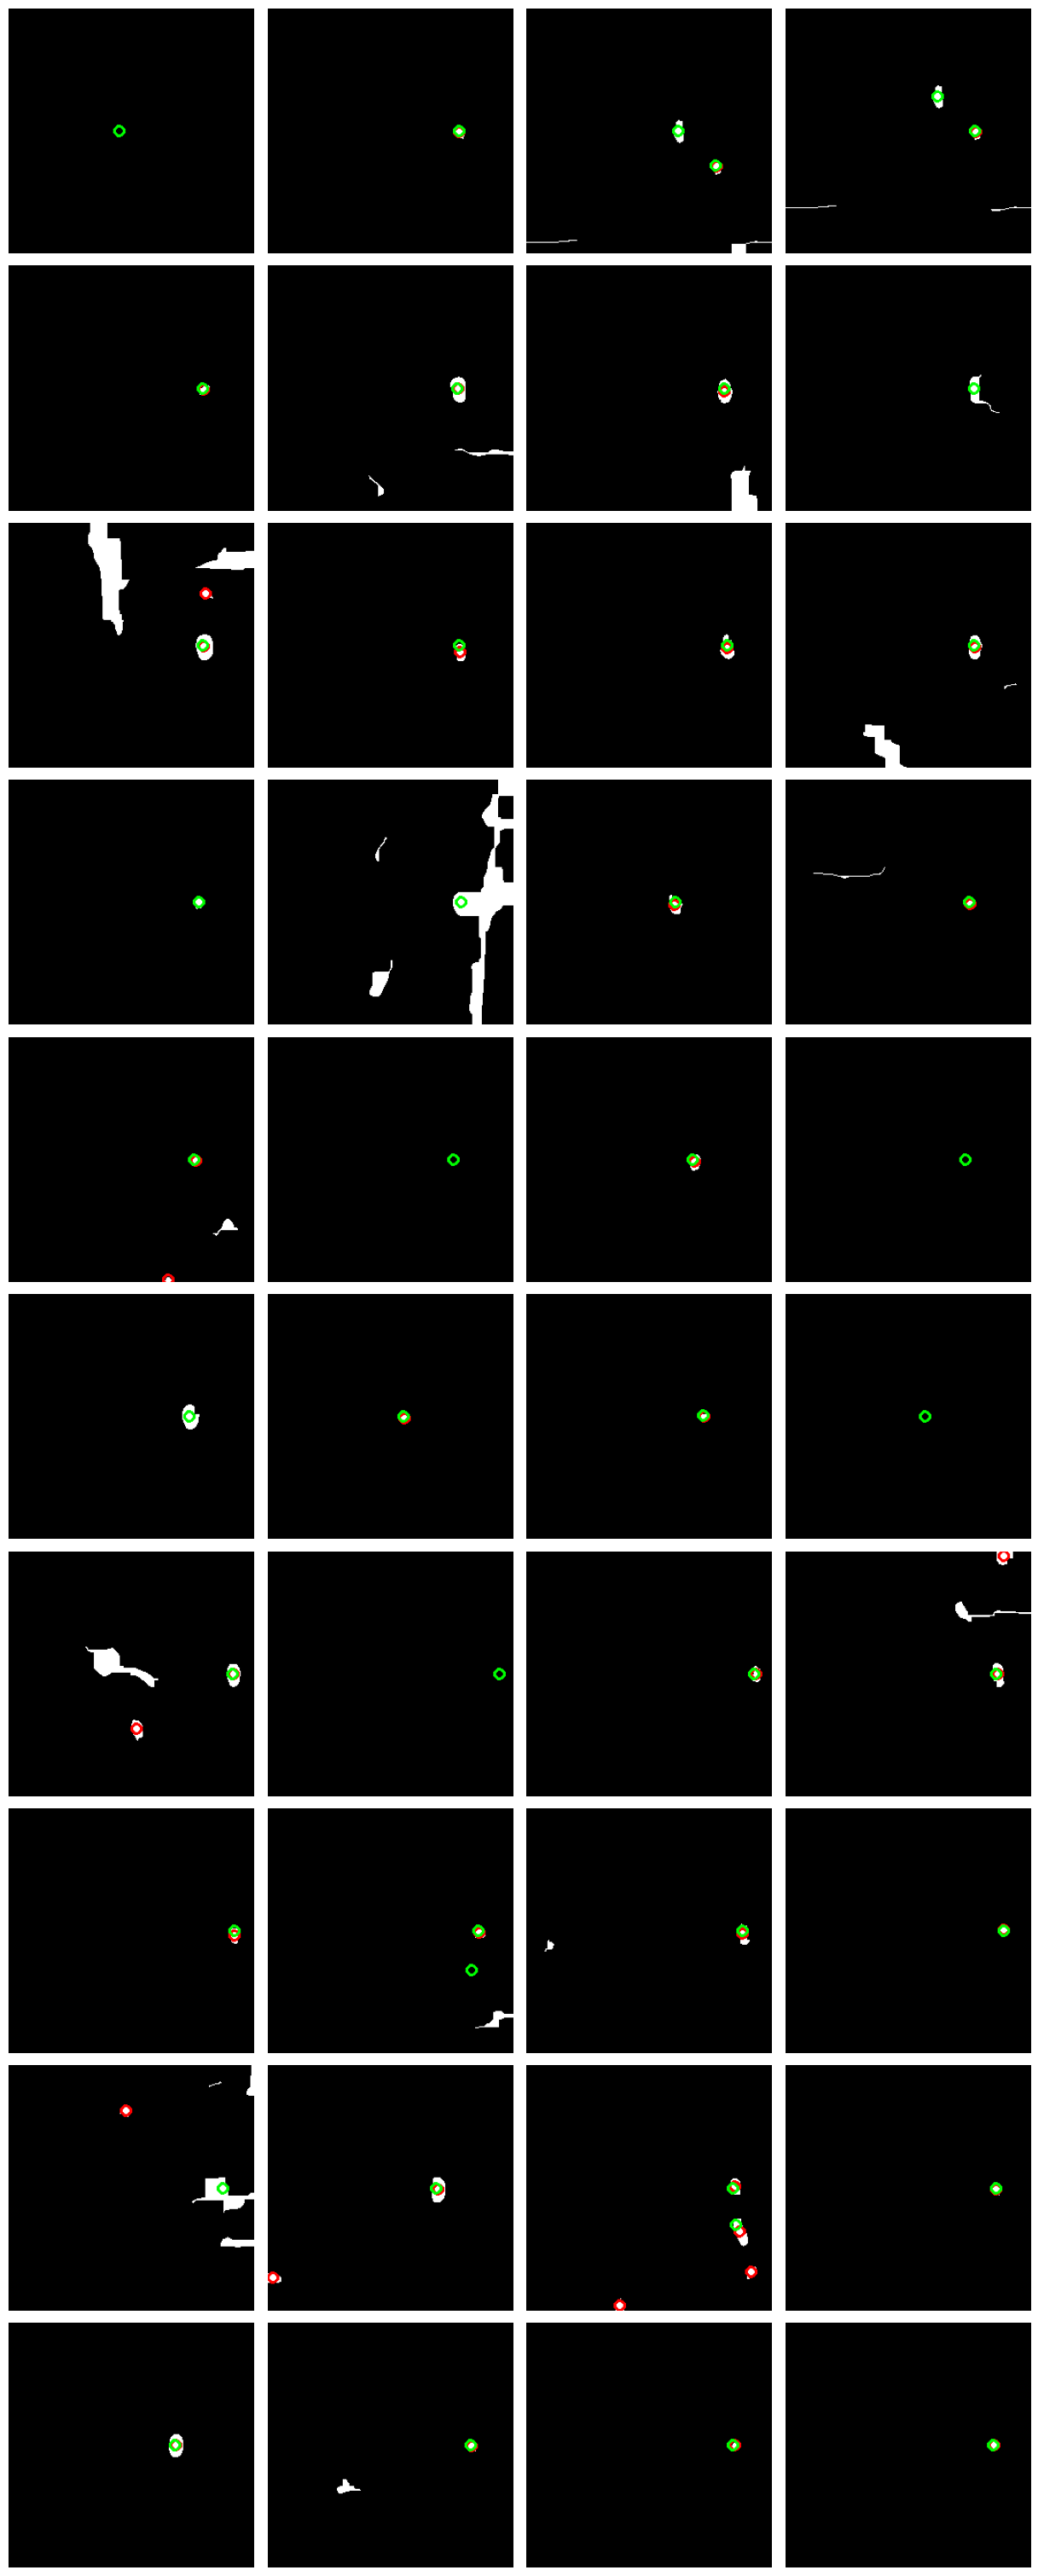

In [18]:
plot_images(detecor.all_transforms["closing"], pred_centroids=predictions, true_centroids=masks_centroids, n=4*10)

input


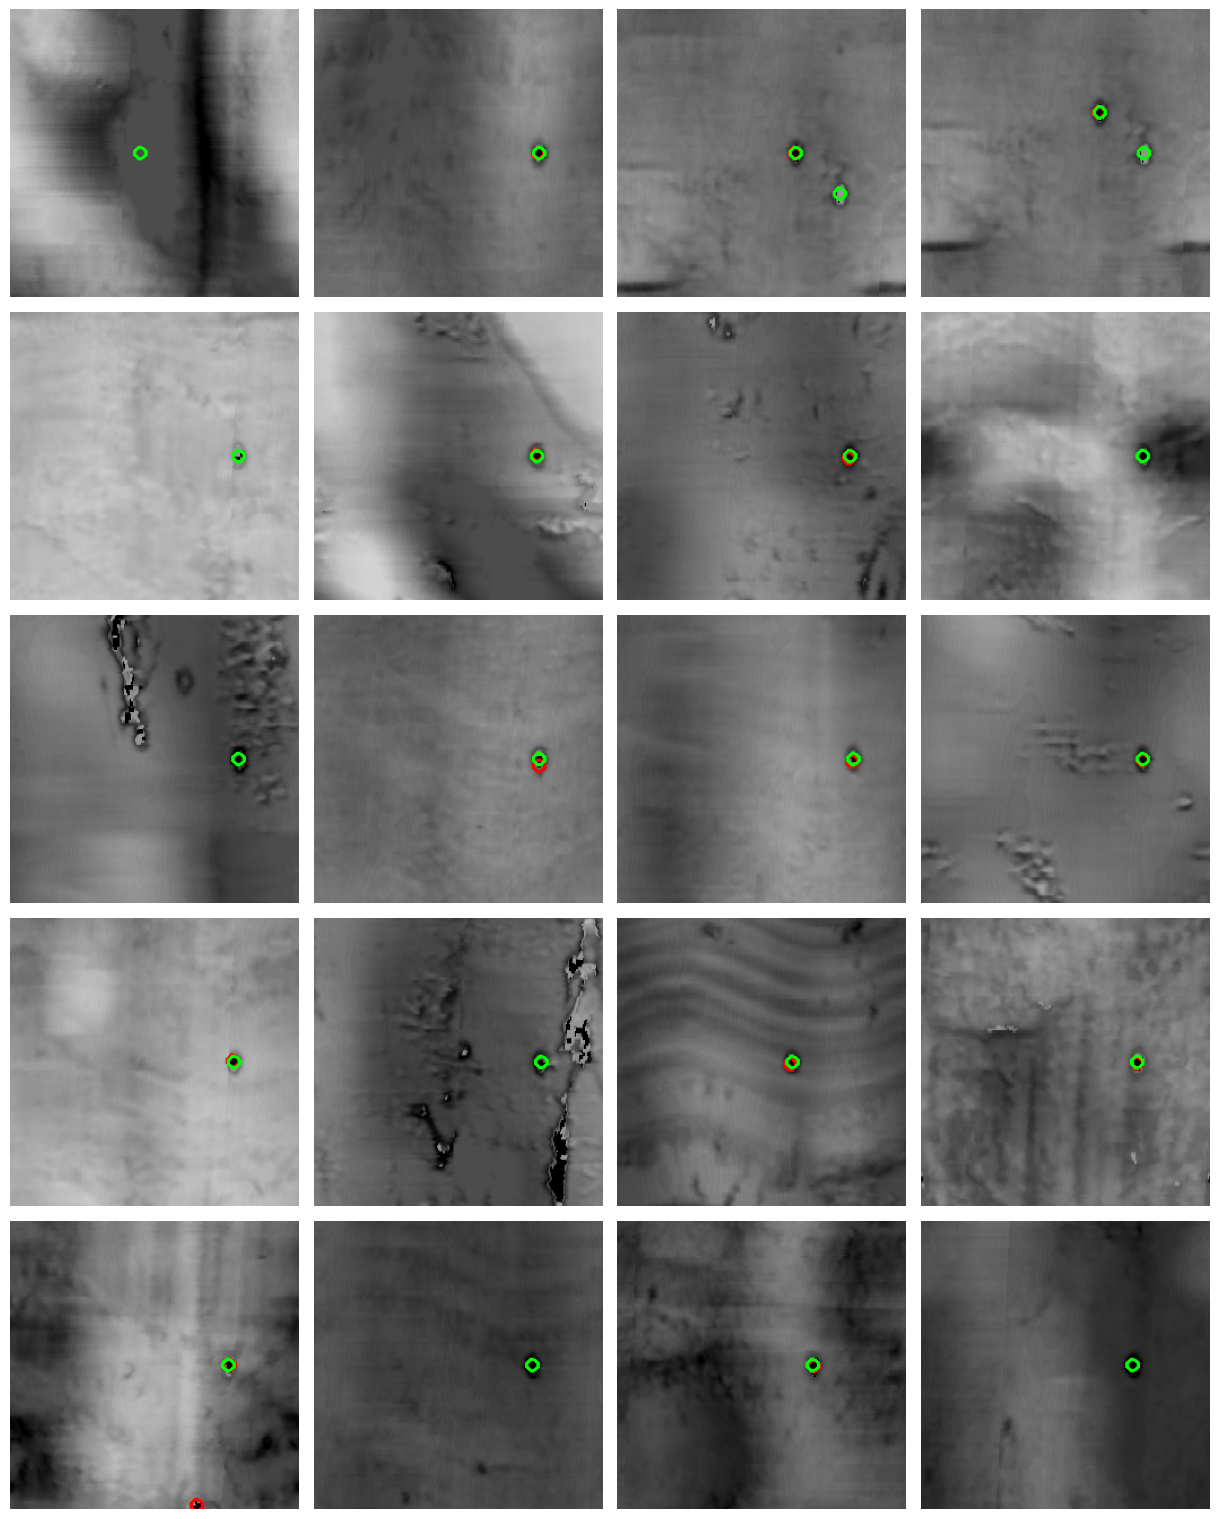

canny


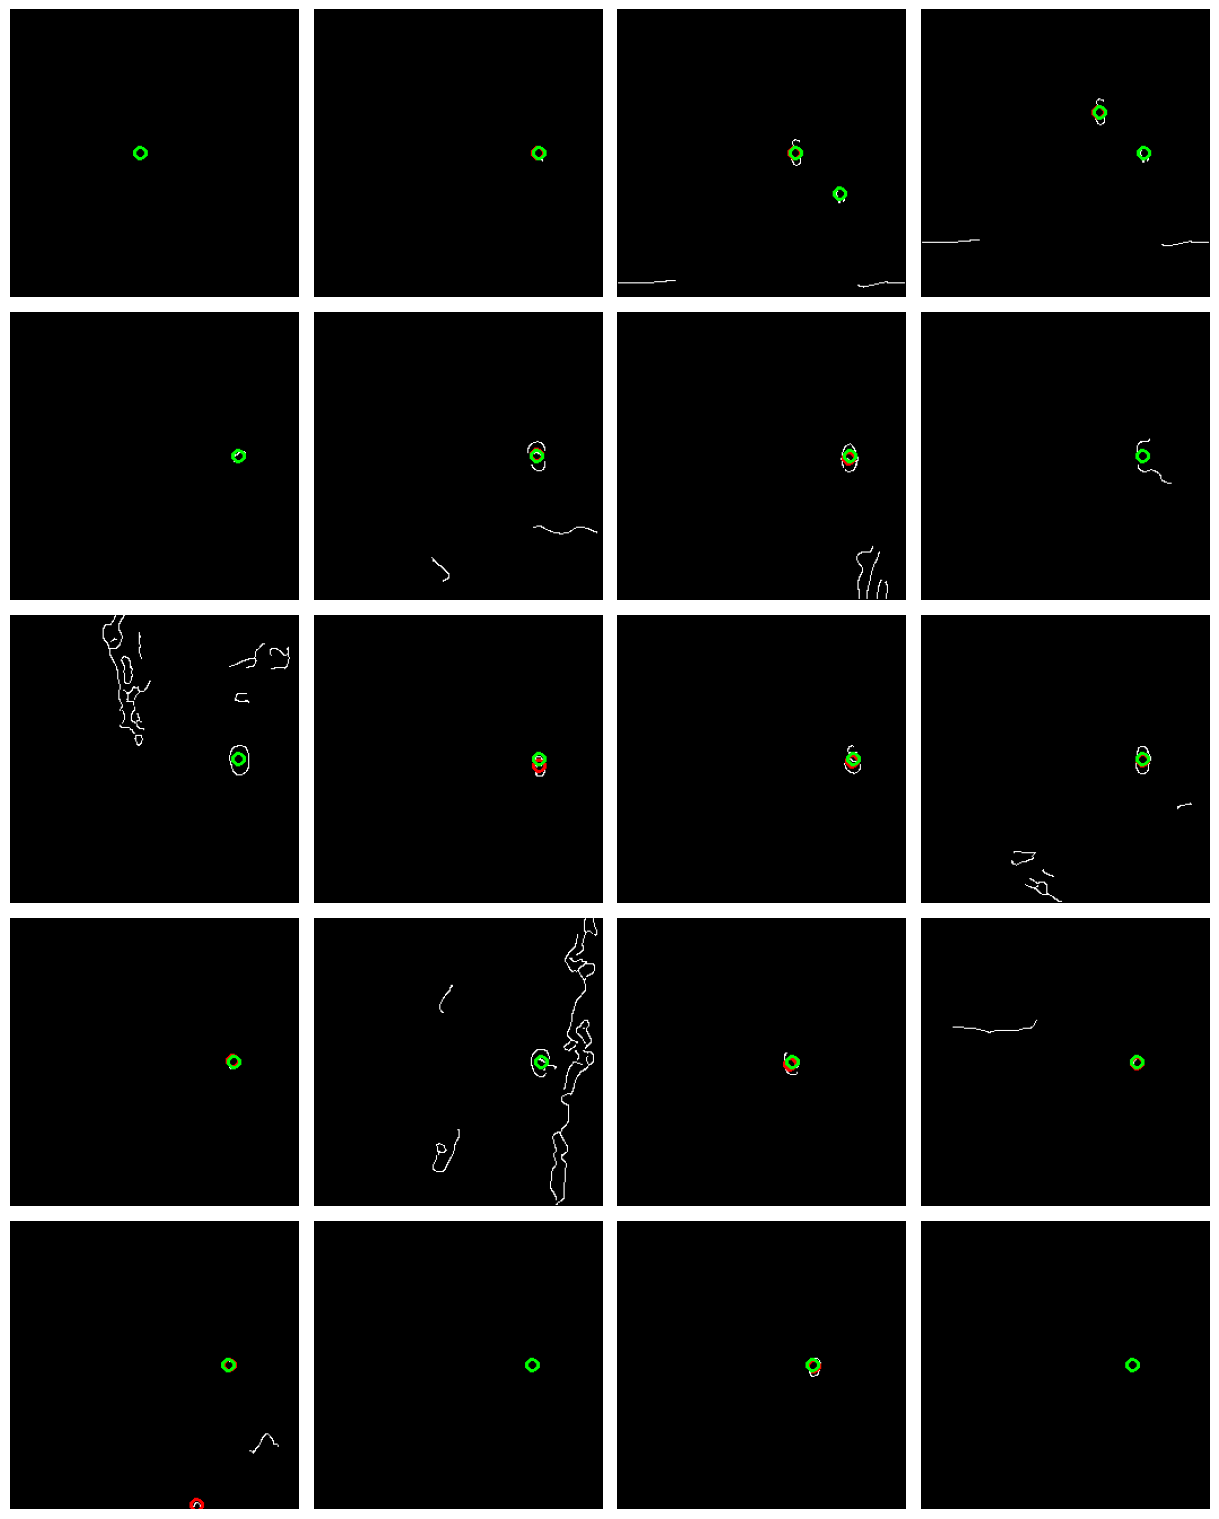

closing


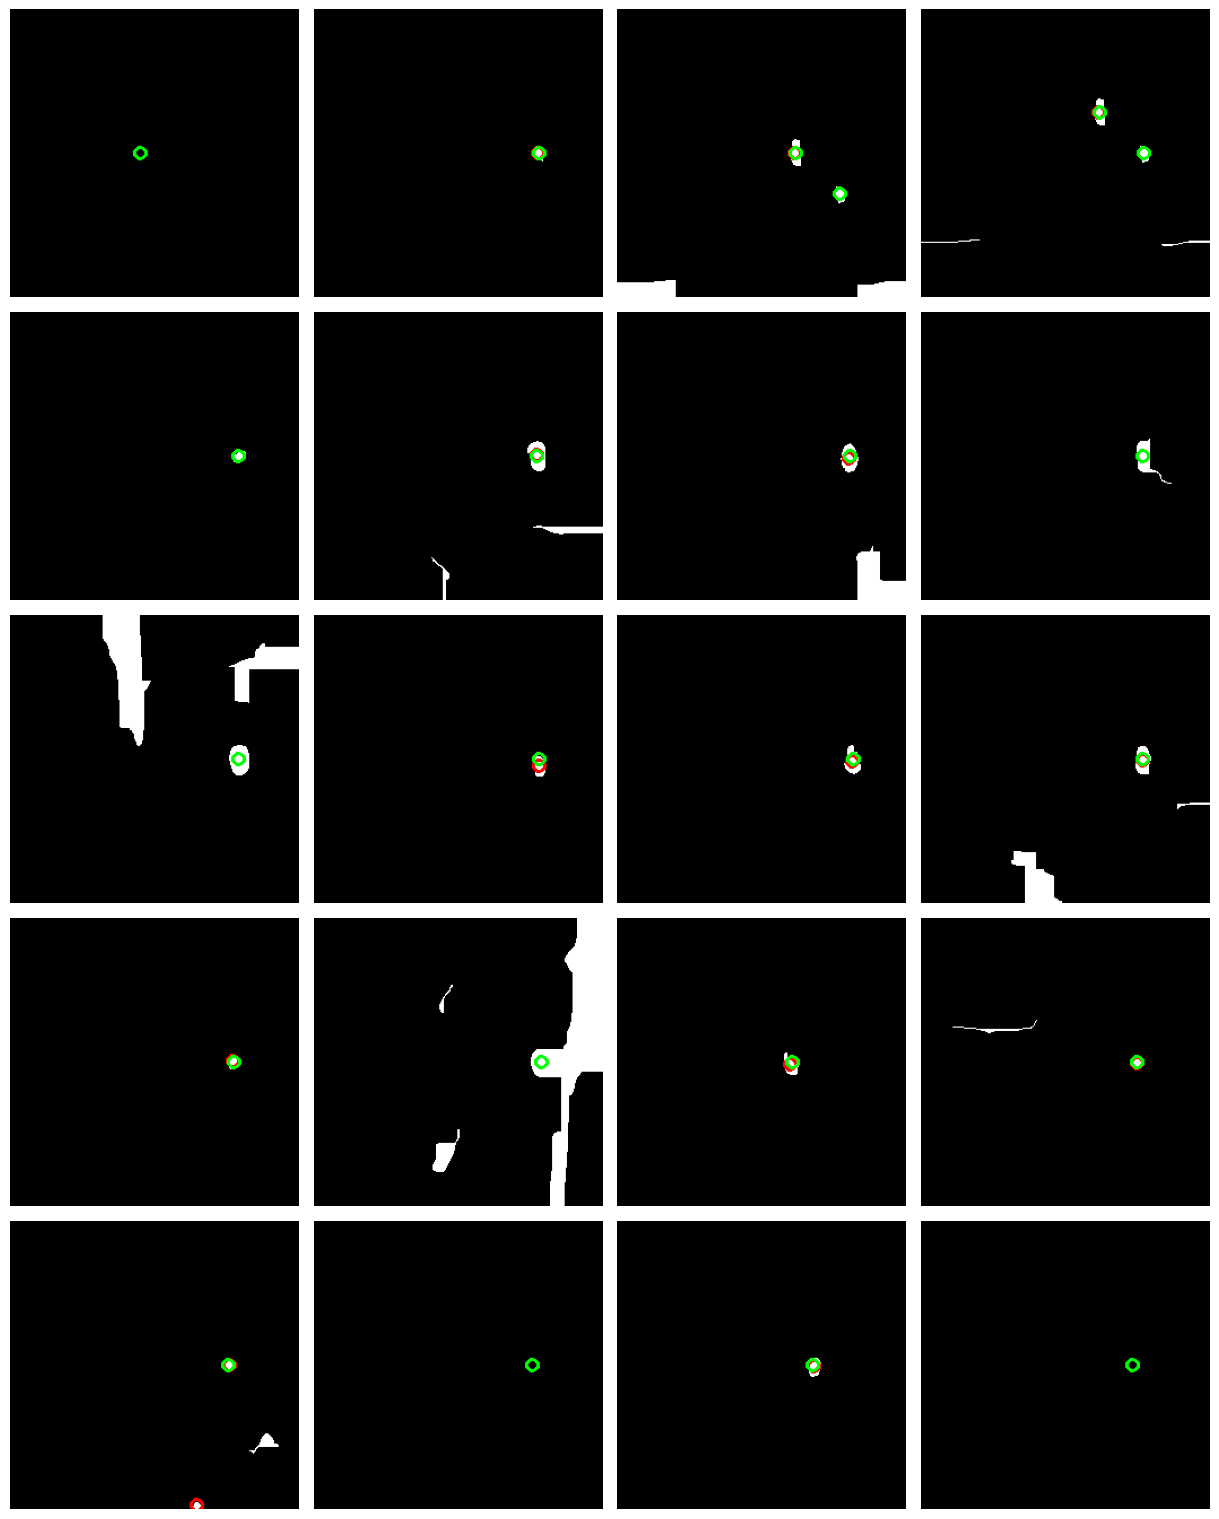

output


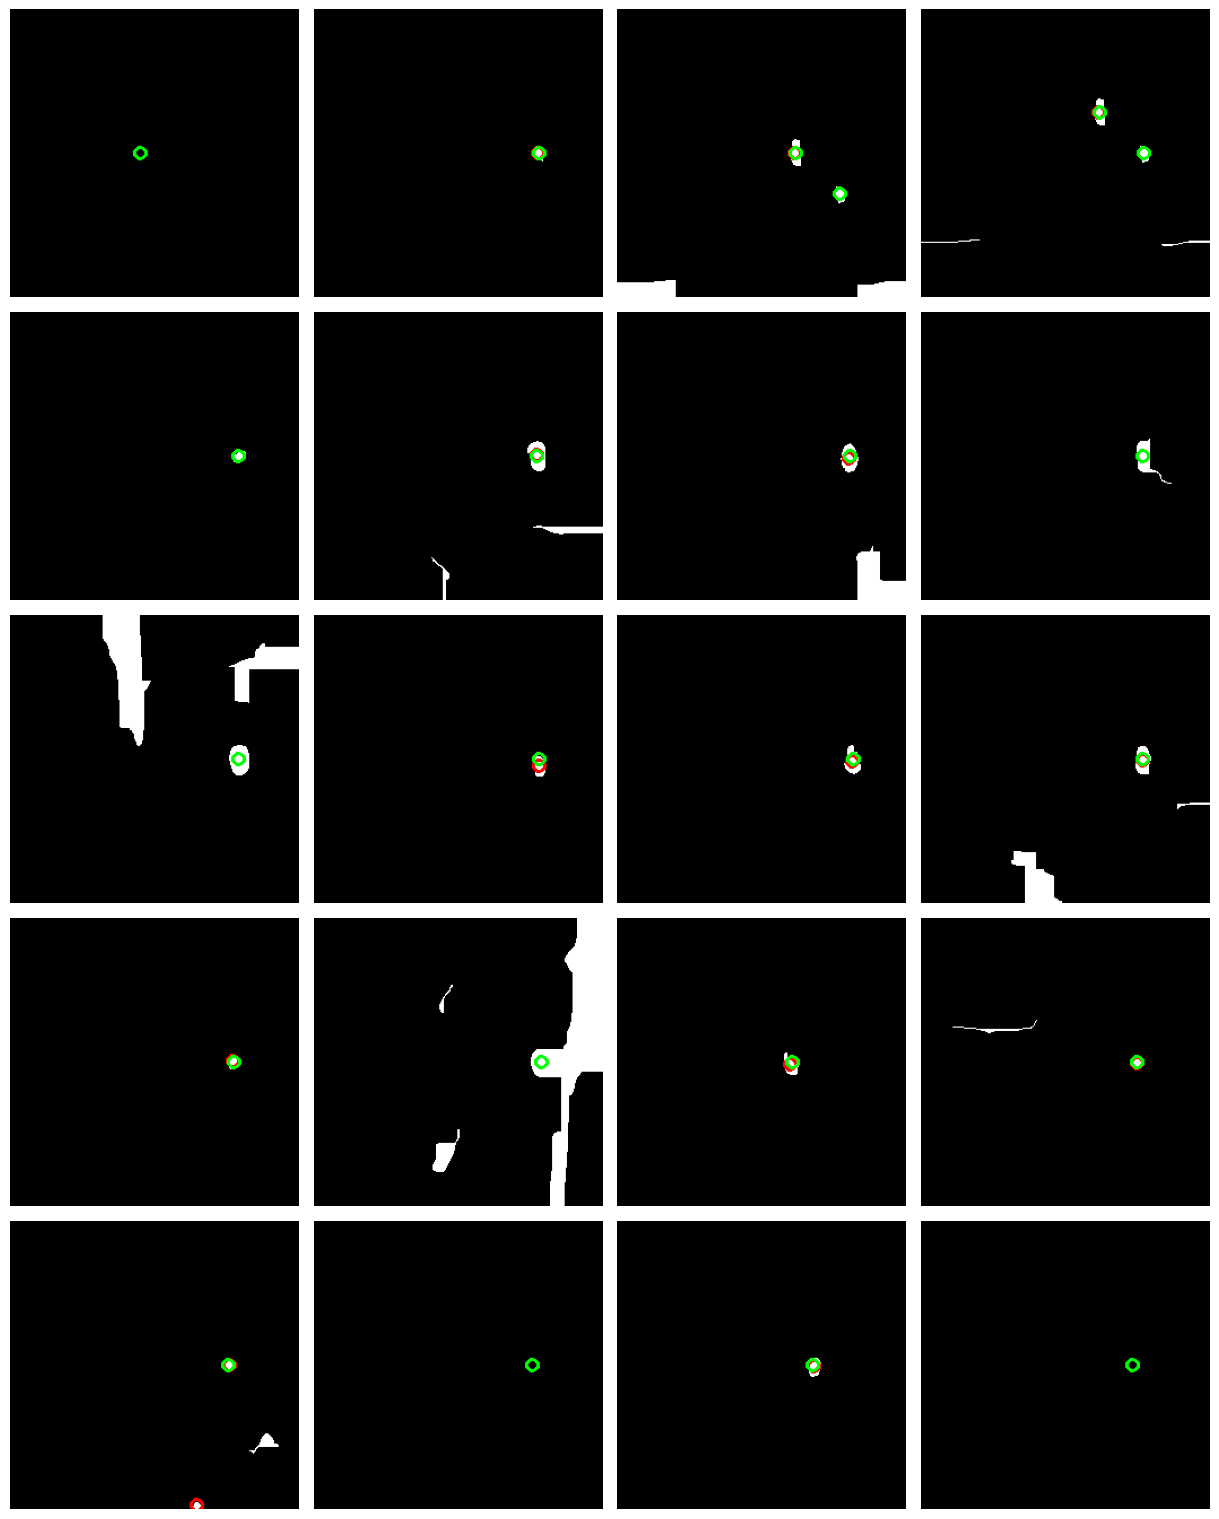

In [12]:
for i in detecor.all_transforms:
    print(i)
    plot_images(detecor.all_transforms[i], pred_centroids=predictions, true_centroids=masks_centroids, n=4*5)